# Paper Reproducing
In this part we will attempt to reproduce the correlation results from the original paper. This is done both to provide a sanity check, but also to create the general functions we will use later to calcuate the correlation on the data from the models

In [1]:
import pandas as pd
import netCDF4 as nc
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import interpolate
import scipy
import tqdm
import matplotlib.colors as mcolors
from helpers import process_h as helper
from helpers import visualize_h as vis_helper


In [2]:
data_relative_path = os.path.join('..', 'Data')
precipitation_path = os.path.join(data_relative_path,'CMIP6','Precipitation')
WTIO_path = os.path.join(data_relative_path,'CMIP6','WTIO')
SEIO_path = os.path.join(data_relative_path,'CMIP6','SEIO')
CHIRPS_path = os.path.join(data_relative_path,'CHIRPS2')

# Constants 

In [3]:
df_dmi = pd.read_csv(f"{data_relative_path}/PSL/DMI.csv")
df_wtio = pd.read_csv(f"{data_relative_path}/PSL/WTIO.csv")
df_seio = pd.read_csv(f"{data_relative_path}/PSL/SEIO.csv")
dmi_mat = scipy.io.loadmat(f"{data_relative_path}/DMI/DMI.mat")

bounds_lat = [20, 40]
bounds_lon = [20, 50]
boundaries = bounds_lon + bounds_lat

In [4]:
df_dmi.set_index('Year', inplace=True)
df_wtio.set_index('Year', inplace=True)
df_seio.set_index('Year', inplace=True)

In [5]:
df_dmi = df_dmi.query('Year >= 1981 and Year <= 2010')
df_wtio = df_wtio.query('Year >= 1981 and Year <= 2010')
df_seio = df_seio.query('Year >= 1981 and Year <= 2010')

In [6]:
dmi_oct = df_dmi['10']
wtio_oct = df_wtio['10']
seio_oct = df_seio['10']
obs_iod = pd.concat([dmi_oct, wtio_oct, seio_oct], axis=1, keys=['DMI', 'WTIO', 'SEIO'])

0.7453778857286607

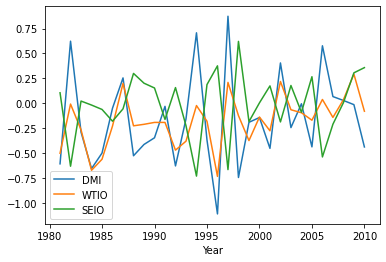

In [7]:
obs_iod.plot()
plt.legend(['DMI', 'WTIO', 'SEIO'])
obs_iod.corr()['DMI']['WTIO']

Next, we will plot the correlation between the DMI and the precipitation data.

In [8]:
dmi_oct.values

array([-0.606,  0.623, -0.288, -0.654, -0.498, -0.048,  0.255, -0.525,
       -0.412, -0.345, -0.03 , -0.627, -0.156,  0.707, -0.367, -1.108,
        0.873, -0.743, -0.19 , -0.142, -0.451,  0.405, -0.243, -0.004,
       -0.436,  0.577,  0.068,  0.029, -0.013, -0.437])

In [9]:
chirps_data_us = nc.Dataset(f"{CHIRPS_path}/chirps_octobers_middle_east_1981_2010.nc") # CHIRPS_Monthly_precipitation
chirps_precip_data_us = chirps_data_us['precip'][:]
chirps_data_asaf = nc.Dataset(f"{CHIRPS_path}/CHIRPS_Monthly_precipitation.nc") # 
chirps_precip_data_asaf = chirps_data_asaf['precip'][:]


print(dmi_oct.values)
print(dmi_mat['DMI_Oct_1981_2022'][:, 1])

[-0.606  0.623 -0.288 -0.654 -0.498 -0.048  0.255 -0.525 -0.412 -0.345
 -0.03  -0.627 -0.156  0.707 -0.367 -1.108  0.873 -0.743 -0.19  -0.142
 -0.451  0.405 -0.243 -0.004 -0.436  0.577  0.068  0.029 -0.013 -0.437]
[-0.446784  0.783206 -0.128064 -0.494643 -0.338775  0.111347  0.413988
 -0.365183 -0.252863 -0.185623  0.129056 -0.467234  0.00394   0.866418
 -0.207052 -0.949133  1.03314  -0.583844 -0.0299    0.0172   -0.290983
  0.564386 -0.0833    0.155786 -0.276055  0.736177  0.227506  0.188087
  0.146896 -0.277693  0.515796  0.269756 -0.00836   0.300327  0.642057
 -0.211894  0.175058  0.844035  1.12348   0.233236  0.0686   -0.531142]


In [10]:
corr_map_us = helper.calc_dmi_precp_corr_vec(dmi_mat['DMI_Oct_1981_2022'][:, 1][:30], chirps_precip_data_us)
# corr_map_asaf = helper.calc_dmi_precp_corr_vec(dmi_oct.values, chirps_data_asaf.variables['precip'][9::12, 280:360, 800:920][:30, :,:])

corr_map_asaf = helper.calc_dmi_precp_corr_vec(dmi_mat['DMI_Oct_1981_2022'][:, 1], chirps_data_asaf.variables['precip'][9::12, 280:360, 800:920])

# corr_map_us = cor_map(dmi_oct.values, chirps_precip_data_us)


In [11]:
alpha = 0.05
corr_map_tested = np.where(helper.calc_corr_t_test(corr_map_us) > alpha, 0, corr_map_us)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
vis_helper.plot_corr_heatmap_flexible(axes[0], corr_map_us, boundaries, 'Correlation between DMI and Precipitation', 'Corr. between DMI and CHIRPS - Our Data', 0)
# vis_helper.plot_corr_heatmap_flexible(axes[1], corr_map_asaf, boundaries, 'Correlation between DMI and Precipitation', 'Corr. between DMI and CHIRPS - Asaf Data', 0)

ValueError: operands could not be broadcast together with shapes (400,600) (80,120) 

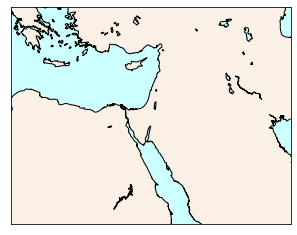

In [13]:
############# PLOT MAPS 4 #############
# Create a 2D meshgrid for the latitude and longitude data
lon = chirps_data_asaf['longitude'][800:920]
lat = chirps_data_asaf['latitude'][280:360]
lon_2d, lat_2d = np.meshgrid(lon, lat)
fig = plt.figure()
ax = plt.axes()

#map = Basemap(projection='cyl', llcrnrlon=33.,llcrnrlat=29.,urcrnrlon=37.,urcrnrlat=34., resolution='i', ax=ax)
map = Basemap(projection='merc',llcrnrlon=20,llcrnrlat=20,urcrnrlon=50,urcrnrlat=40,resolution='i') # projection, lat/lon extents and resolution of polygons to draw
# resolutions: c - crude, l - low, i - intermediate, h - high, f - full
map.drawcoastlines()
map.drawstates()
map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
map.drawcounties() # you can even add counties (and other shapefiles!)

#map.pcolormesh(lon_2d, lat_2d, pressureS[t,:,:], latlon=True, cmap='coolwarm') #Can change variables and index for time - also in line 48
cmap = 'coolwarm'
#vmin = 100000
#vmax = 102000

#cs = map.contour(lon_2d, lat_2d, pressureS[t, :, :], latlon=True, cmap=cmap)#, vmin=vmin, vmax=vmax) #lines
cs = map.contourf(lon_2d, lat_2d, np.squeeze(corr_map_tested), latlon=True, cmap=cmap)#, vmin=vmin, vmax=vmax) #color lines
#cs = map.pcolormesh(lon_2d, lat_2d, pressureS[t, :, :], latlon=True, cmap=cmap)#, vmin=vmin, vmax=vmax)
#Diverging Colormaps: 'coolwarm', 'RdBu_r', 'seismic', 'viridis', 'plasma', 'inferno', 'cividis', 'magma', 'tab10', ''
# Adding pressure isobar lines
#levels = np.arange(100000, 102000, 100) # define pressure levels
#contour = map.contour(lon_2d, lat_2d, pressureS[t, :, :], levels=levels, latlon=True, colors='k', linewidths=1)

# Adding labels to contour lines
#plt.clabel(cs, inline=1, fontsize=10, fmt='%1.0f')

map.colorbar()
#cbar = map.colorbar(cs, location='bottom', pad="5%")
#cbar.set_label('Pressure (Pa)')
parallels = np.arange(min(lat),max(lat),1.) # make latitude lines ever 5 degrees from 30N-50N
meridians = np.arange(min(lon),max(lon),1.) # make longitude lines every 5 degrees from 95W to 70W
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=8, dashes=[1, 3], color='lightgray', linewidth=0.5)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8, dashes=[1, 3], color='lightgray', linewidth=0.5)

#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
ax.set_ylabel('Latitude', loc='center' , labelpad=20.0)
ax.set_xlabel('Longitude', loc='center', labelpad=13.0)
plt.title('Correlation between DMI and CHIRPS') #Change title per variable

plt.show()

In [15]:
corr_map_us.shape

(400, 600)

In [17]:
corr_map_asaf.shape

(80, 120)